Using TensorFlow backend.


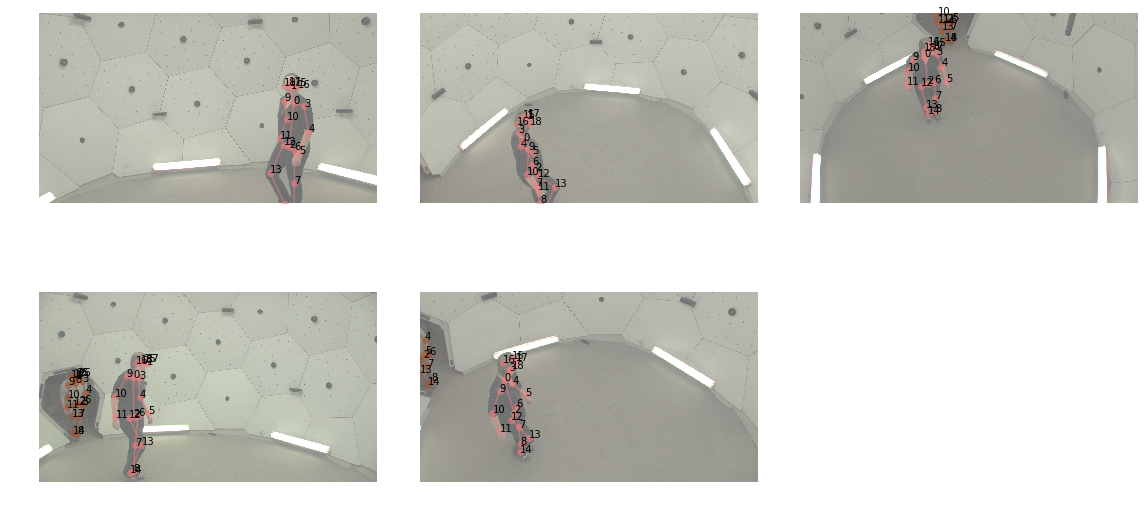

In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import epfl_campus
from time import time

root = Settings['CMU']['data_root']
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d
from mvpose.data import cmu_panoptic
from cselect import color as cs
from random import shuffle


from openpose import OpenPose

loader = Loader(with_gpu=True)

FRAME = 8642

nodes = [0, 1, 2, 3, 4]
panels = [0, 0, 0, 0, 0]
#seq_name = '160224_haggling1'
seq_name = '160422_ultimatum1'

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)

fig = plt.figure(figsize=(16,8))

# Edges between joints in the body skeleton
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1


colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
          'teal', 'white', 'cornflowerblue', 'limegreen',
         'rosybrown', 'sienna', 'plum', 'slategrey',
         'orchid', 'lightblue', 'azure', 'aliceblue',
         'darkblue', 'lightcoral', 'silver', 'mediumpurple',
         'lightskyblue']
shuffle(colors)

# n = 18
# colors = cs.rangecolor(n, (255, 0, 0), (0, 256, 0))/255

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
#     ax.set_xlim([1200, 1800])
#     ax.set_ylim([1080, 300])
    
    for pid, points3d_weighted in Y:
        pts3d = points3d_weighted[:, 0:3].astype('float32')
        pts2d = cam.projectPoints(pts3d)
        pts2dT = pts2d.transpose()
        ax.scatter(pts2d[:, 0], pts2d[:, 1], color=colors[pid], alpha=0.5)
        for edge in body_edges:
            ax.plot(pts2dT[0, edge], pts2dT[1, edge],
                    color=colors[pid], alpha=0.5)
        for idx, (x, y) in enumerate(pts2d):
            if x >= 0 and x < w:
                if y >= 0 and y < h:
                    ax.text(x, y, str(idx))
        
    
plt.tight_layout()

plt.show()

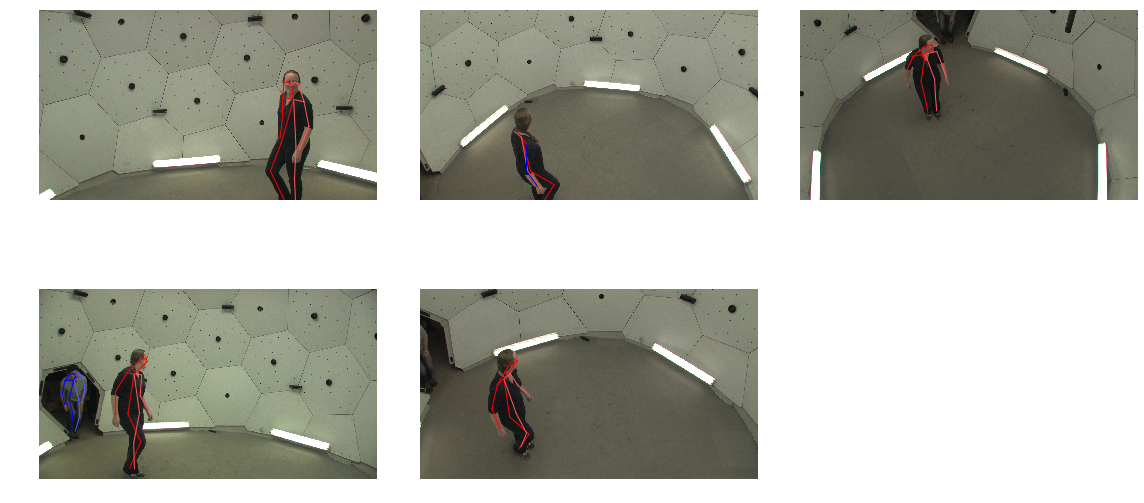

In [2]:
pe = OpenPose(tmp=tmp)
predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, FRAME)

colors = ['red', 'blue', 'green', 'yellow', 'teal', 'magenta']

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(2, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
    
    for pid, human in enumerate(pred):
        draw_mscoco_human2d(ax, human[:, 0:2], color=colors[pid])

    
plt.tight_layout()
plt.show()

In [3]:
def calculate_pcp_score(Y, detections):
    alpha = 0.5
    Humans = kth.transform3d_from_mscoco(detections)
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
    
    Y_kth = []
    for _, gt in Y:
        Y_kth.append(gt[:, 0:3])
    Y_kth = kth.transform3d_from_mscoco(Y_kth)
        
    for gtid, gt in enumerate(Y_kth):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs
        
def print_pcp(L_Arms, U_Arms, L_Legs, U_Legs, GTIDs):
    print("")
    for la, ua, ll, ul, gid in zip(L_Arms, U_Arms, L_Legs, U_Legs, GTIDs):
        print('gtid:', gid)
        print('\tla:', la)
        print('\tua:', ua)
        print('\tll:', ll)
        print('\tul:', ul)
    
    print('avg')
    print('\tla:', np.mean(L_Arms))
    print('\tua:', np.mean(U_Arms))
    print('\tll:', np.mean(L_Legs))
    print('\tul:', np.mean(U_Legs))
    print("\n\tavg*:", np.mean([
        np.mean(L_Arms), np.mean(U_Arms), 
        np.mean(L_Legs), np.mean(U_Legs)
    ]))

In [4]:
import numpy.linalg as la
from scipy.optimize import linear_sum_assignment

def calculate_closeness(y, y_pred):
    scale_to_mm = 10
    assert len(y) == 18
    assert len(y_pred) == 18
    y = y[:, 0:3]
    n = 0
    distances = []
    for jid, (a, b) in enumerate(zip(y, y_pred)):
        if b is None:
            continue
        d = la.norm(a-b) * scale_to_mm
        distances.append(d)
    return np.squeeze(np.mean(distances))


def find_closest_detections_to_gt(Y, humans):
    n = len(Y)
    m = len(humans)
    C = np.zeros((n, m))
    
    print('#gt:', n)
    print('#d:', m)
    
    for i in range(n):
        for j in range(m):
            C[i, j] = calculate_closeness(Y[i][1], humans[j])
    
    scores = []
    rows, cols = linear_sum_assignment(C)
    for gt_id, pr_id in zip(rows, cols):
        scores.append(C[gt_id, pr_id])
    return scores

In [5]:
FRAME = 112
seq_name = '160906_pizza1'

step 1: elapsed 2.937265634536743
step 2: elapsed 0.032137393951416016
step 3: elapsed 0.8412950038909912
step 4: elapsed 3.5691957473754883
-------------------------------------------
Handle transitivity:
	Intra:		 0
	Intra(choice):	 0
	Inter:		 0
	Inter(choice):	 185
-------------------------------------------
	Time =  33  ms
	result: 0

	Total cost: 75.86420453610071

# valid points:		 132
# invalid points:	 22
step 5: elapsed 0.03845667839050293
(smart candidate selection) [
	Time =  5  ms
	result: 0

	Total cost: 44.85786306355729
] (smart candidate selection)
step 6: elapsed 0.025484323501586914

total elapsed: 7.444753646850586
#Humans 4
#gt: 4
#d: 4

-- best fit --
[27.49379990331598, 18.468203739033317, 56.50714529386766, 35.5793132320938]
	min: 18.468203739033317
	max: 56.50714529386766
	avg: 34.51211554207769


gtid: 0
	la: 1.0
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 1
	la: 1.0
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 2
	la: 0.5
	ua: 0.5
	ll: 1.0
	ul: 1.0
gtid: 3
	la: 0
	ua: 1.0
	ll: 0.5
	

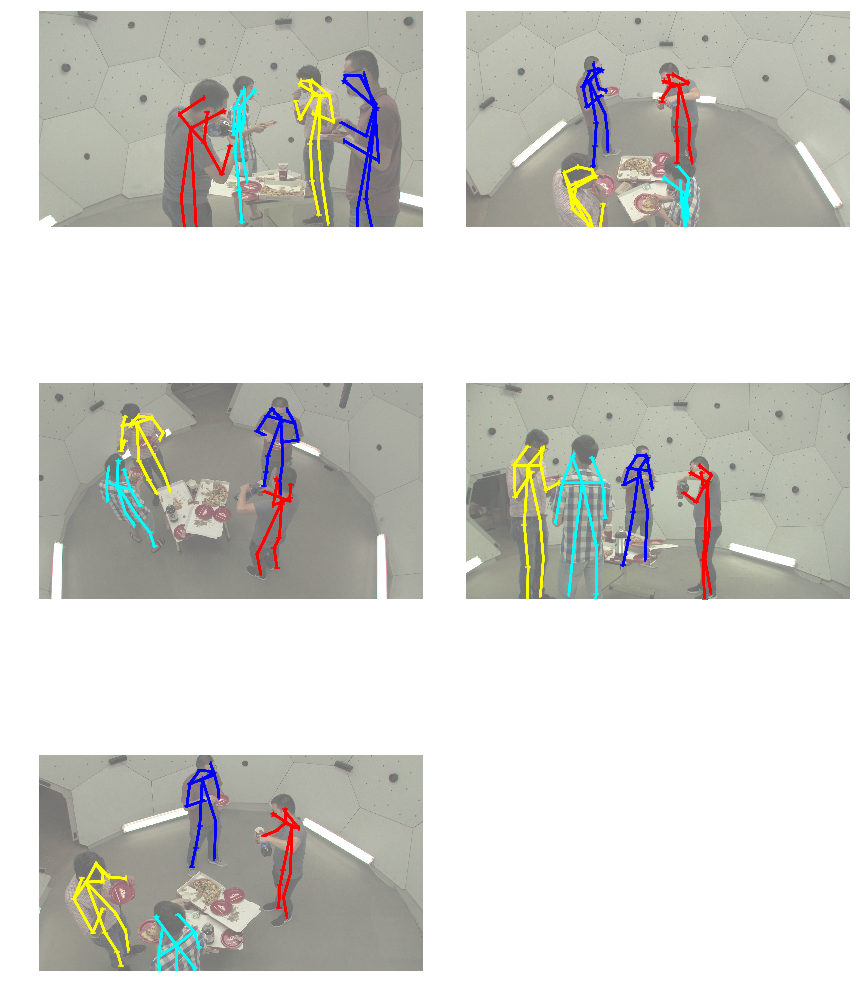

In [6]:
from mvpose import settings
import paf_loader
from mvpose import pose
from mvpose.plot.limbs import draw_mscoco_human

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)
Y = cmu_panoptic.transform_y(Y)

# -- remove cameras --
# Im = Im[0:3]
# Y = Y[0:3]
# Calib = Calib[0:3]
# -- {end} remove cameras --

params = settings.get_settings(
    max_epi_distance=40, 
    scale_to_mm=10, 
    gp_max_radius=40,
    pp_conflict_overlap=0.7)

# -- we always use gpu --
assert loader.with_gpu
heatmaps, pafs = loader.load_confidence_map_and_paf('cmu' + seq_name, 
                                                        Im, FRAME,
                                                        dir=tmp)

_start = time()
Debug, detections = pose.estimate(
    Calib, heatmaps, pafs, settings=params, debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)

Humans = detections
print("#Humans", len(Humans))

fig = plt.figure(figsize=(12,16))

colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
          'teal', 'white', 'cornflowerblue', 'limegreen']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid], linewidth=2)
    
# ===
closest = find_closest_detections_to_gt(Y, Humans)
print('')
print('-- best fit --')
print(closest)
print('\tmin: ' + str(np.min(closest))) 
print('\tmax: ' + str(np.max(closest)))
print('\tavg: ' + str(np.mean(closest)))

print('')

print_pcp(*calculate_pcp_score(Y, Humans))

print('\n(GRAPH PARTITIONING)')

plt.tight_layout()
plt.show()

elapsed 0.24268364906311035
#d 7
#gt: 4
#d: 7

-- best fit --
[25.477168689105174, 19.79357910921876, 38.470412711091186, 57.21165911004399]
	min: 19.79357910921876
	max: 57.21165911004399
	avg: 35.23820490486478


gtid: 0
	la: 1.0
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 1
	la: 0.5
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 2
	la: 1.0
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 3
	la: 0
	ua: 1.0
	ll: 0
	ul: 1.0
avg
	la: 0.625
	ua: 1.0
	ll: 0.75
	ul: 1.0

	avg*: 0.84375

(BASELINE)


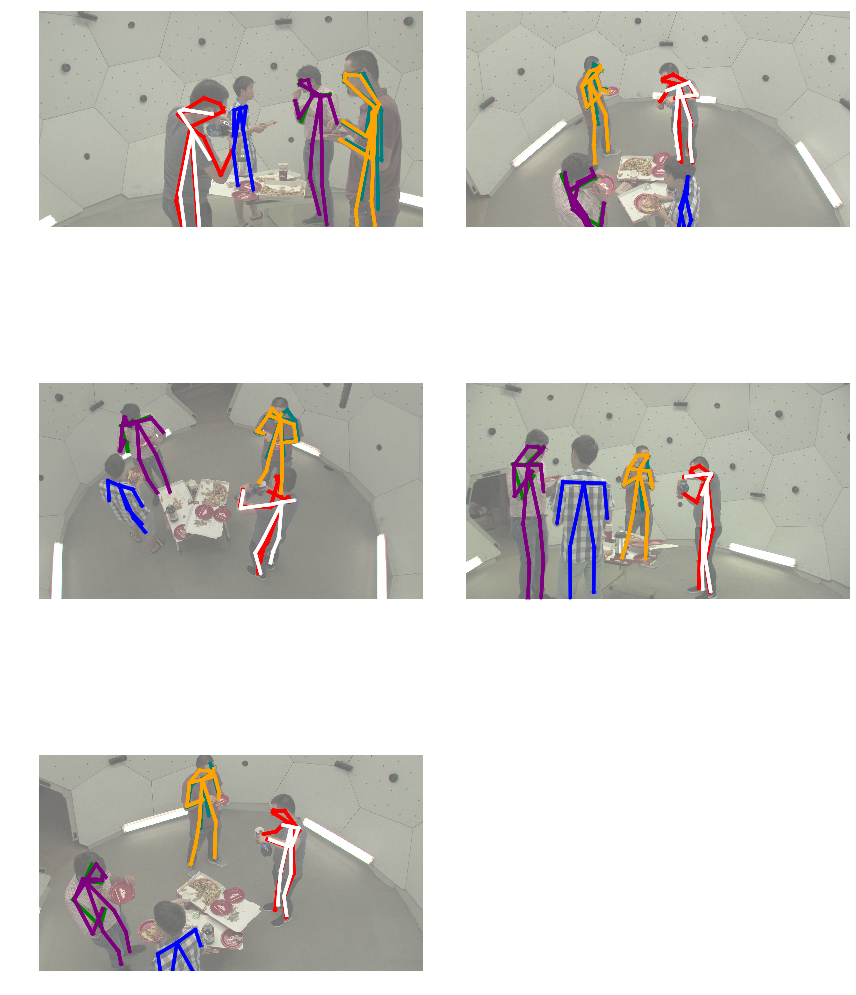

In [7]:
from mvpose.baseline.baseline import estimate

_start = time()
Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)
Y = cmu_panoptic.transform_y(Y)
predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, FRAME)

# -- remove cameras --
# Im = Im[0:3]
# Y = Y[0:3]
# predictions = predictions[0:3]
# Calib = Calib[0:3]
# -- {end} remove cameras --


humans, H = estimate(Calib, predictions, epi_threshold=40, 
                     get_hypothesis=True)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(12,16))

print('#d', len(humans))
colors = ['red', 'blue', 'green', 'teal', 'orange', 'white', 'purple']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(3, 2, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(humans):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)

# ===
closest = find_closest_detections_to_gt(Y, humans)
print('')
print('-- best fit --')
print(closest)
print('\tmin: ' + str(np.min(closest))) 
print('\tmax: ' + str(np.max(closest)))
print('\tavg: ' + str(np.mean(closest)))

print('')
print_pcp(*calculate_pcp_score(Y, humans))

print('\n(BASELINE)')
    
plt.tight_layout()
plt.show()

In [8]:
#valid_frames = list(range(8630, 9230, 4))
valid_frames = list(range(8630, 8642, 4))
print('#frames', len(valid_frames))

def handle_frame(frame):
    Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=frame)
    Y = cmu_panoptic.transform_y(Y)
    predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, frame)
    humans, H = estimate(Calib, predictions, epi_threshold=40, 
                     get_hypothesis=True)
    
    return find_closest_detections_to_gt(Y, humans)
    
TOTAL = []
TOTAL_AVG = []
    
frame = 9100
_start = time()
scores = handle_frame(frame)
TOTAL.append(scores)
_end = time()
print('frame ' + str(frame) + ', elapsed', _end - _start)
    
# for frame in valid_frames:
#     _start = time()
#     scores = handle_frame(frame)
#     TOTAL.append(scores)
#     _end = time()
#     print('frame ' + str(frame) + ', elapsed', _end - _start)
    
print(TOTAL)

#frames 3
Error reading /media/data/tanke/mvpose_data/cmu_panoptic/160906_pizza1/hdPose3d_stage1_coco19/body3DScene_00009100.json
No such file or directory
#gt: 0
#d: 8
frame 9100, elapsed 0.282285213470459
[[]]


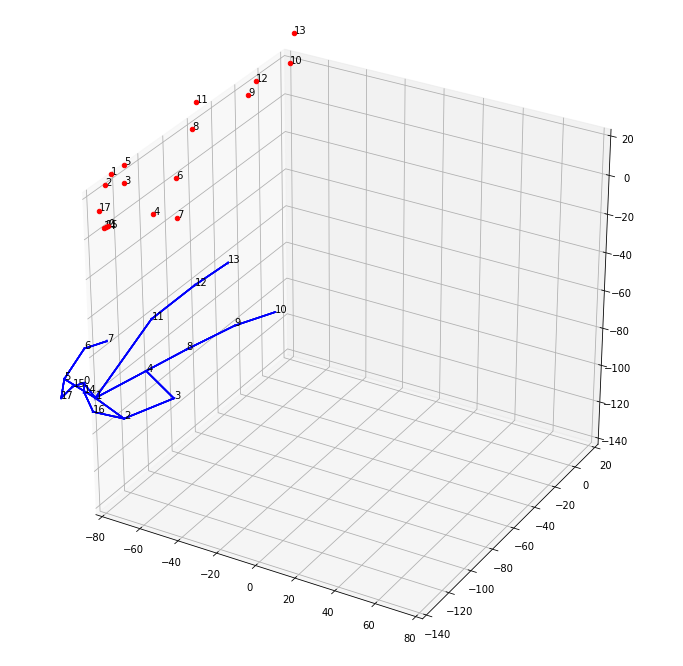

In [9]:
from mvpose.plot.limbs import draw_mscoco_human3d

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)
Y = cmu_panoptic.transform_y(Y)

from mpl_toolkits.mplot3d import Axes3D
item = Y[0][1][:, 0:3]
itemT = np.transpose(item)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# ---
ax.set_xlim([-80, 80])
ax.set_ylim([-140, 20])
ax.set_zlim([-140, 20])
#ax.scatter(item[:, 0], item[:, 1], item[:, 2])
draw_mscoco_human3d(ax, item, color='blue', alpha=0.3)

for idx, (x, y, z) in enumerate(item):
    ax.text( x, y, z, str(idx))

    
# ---
Hum = humans[0]
Hum
for jid, pt in enumerate(Hum):
    if pt is None:
        continue
    ax.scatter(*pt, color='red')
    ax.text(*pt, str(jid))
    
plt.show()

In [10]:
from mvpose.data.serialize import DetectionSerializer

params = settings.get_settings(
    max_epi_distance=40, 
    scale_to_mm=10, 
    gp_max_radius=40,
    pp_conflict_overlap=0.7)

experiment = 'exp2'

In [11]:
def handle(valid_frames, seq_name, PER_GTID_baseline, PER_GTID_model):
    global loader, params
    print('\n\n==============================')
    print('sequence:', seq_name)
    print('\t#frames:', len(valid_frames))
    print('==============================')
    
    model_serialize = DetectionSerializer(['model',
                                           seq_name,
                                           experiment])
    basel_serialize = DetectionSerializer(['basel',
                                           seq_name,
                                           experiment])
    
    for frame in valid_frames:
        _start = time()
        Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=frame)
        Y = cmu_panoptic.transform_y(Y)
        
        # -- remove cameras --
#         Im = Im[0:3]
#         Y = Y[0:3]
#         Calib = Calib[0:3]
        # -- {end} remove cameras --
        
        #----------------------
        # -- simple baseline --
        predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, frame)  
        
        humans = estimate(Calib, predictions, epi_threshold=40)
        
        # ~~ storage ~~
        basel_serialize.store(humans, frame)
        # ~~ storage ~~
        
        for larms, uarms, llegs, ulegs, gtid in zip(*calculate_pcp_score(Y, humans)):
            if not gtid in PER_GTID_baseline:
                PER_GTID_baseline[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID_baseline[gtid]['larms'].append(larms)
            PER_GTID_baseline[gtid]['uarms'].append(uarms)
            PER_GTID_baseline[gtid]['llegs'].append(llegs)
            PER_GTID_baseline[gtid]['ulegs'].append(ulegs)
            PER_GTID_baseline[gtid]['frame'].append(frame)
        
        #----------------------
        # ----- our model -----
        heatmaps, pafs = loader.load_confidence_map_and_paf(
            'cvpr2_cmu' + seq_name, Im, frame, dir=tmp)
        detections = pose.estimate(
            Calib, heatmaps, pafs, settings=params, debug=False)
        
        
        # ~~ storage ~~
        model_serialize.store(detections, frame)
        # ~~ storage ~~
        
        for larms, uarms, llegs, ulegs, gtid in zip(*calculate_pcp_score(Y, detections)):
            if not gtid in PER_GTID_model:
                PER_GTID_model[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID_model[gtid]['larms'].append(larms)
            PER_GTID_model[gtid]['uarms'].append(uarms)
            PER_GTID_model[gtid]['llegs'].append(llegs)
            PER_GTID_model[gtid]['ulegs'].append(ulegs)
            PER_GTID_model[gtid]['frame'].append(frame)
        
        _end = time()
        print("\t[" + seq_name + '] frame: %05d' % frame + ', |d|:', round(_end - _start, 3))
        
    model_serialize.save()
    basel_serialize.save()
    
STEPS = 2

# ============

valid_frames = list(range(8630, 9230, STEPS))
seq_name = '160422_ultimatum1'

ULT_PER_GTID_baseline = {}
ULT_PER_GTID_model = {}

handle(valid_frames, seq_name, 
       ULT_PER_GTID_baseline, ULT_PER_GTID_model)

# ============

valid_frames = list(range(3250, 3850, STEPS))
seq_name = '160224_haggling1'

HAG_PER_GTID_baseline = {}
HAG_PER_GTID_model = {}

handle(valid_frames, seq_name, 
       HAG_PER_GTID_baseline, HAG_PER_GTID_model)

# ============

valid_frames = list(range(112, 712, STEPS))
seq_name = '160906_pizza1'

PIZ_PER_GTID_baseline = {}
PIZ_PER_GTID_model = {}

handle(valid_frames, seq_name, 
       PIZ_PER_GTID_baseline, PIZ_PER_GTID_model)



sequence: 160422_ultimatum1
	#frames: 300
	[160422_ultimatum1] frame: 08630, |d|: 22.252
found = 2
	[160422_ultimatum1] frame: 08632, |d|: 50.057
	[160422_ultimatum1] frame: 08634, |d|: 49.811
found = 2
	[160422_ultimatum1] frame: 08636, |d|: 50.53
	[160422_ultimatum1] frame: 08638, |d|: 50.164
	[160422_ultimatum1] frame: 08640, |d|: 51.223
	[160422_ultimatum1] frame: 08642, |d|: 22.846
	[160422_ultimatum1] frame: 08644, |d|: 49.711
	[160422_ultimatum1] frame: 08646, |d|: 50.513
found = 2
	[160422_ultimatum1] frame: 08648, |d|: 50.177
found = 2
	[160422_ultimatum1] frame: 08650, |d|: 51.273
	[160422_ultimatum1] frame: 08652, |d|: 49.948
	[160422_ultimatum1] frame: 08654, |d|: 52.223
	[160422_ultimatum1] frame: 08656, |d|: 50.384
	[160422_ultimatum1] frame: 08658, |d|: 51.063
	[160422_ultimatum1] frame: 08660, |d|: 50.275
	[160422_ultimatum1] frame: 08662, |d|: 50.324
	[160422_ultimatum1] frame: 08664, |d|: 50.434
	[160422_ultimatum1] frame: 08666, |d|: 48.759
	[160422_ultimatum1] fra

	[160422_ultimatum1] frame: 08930, |d|: 52.845
	[160422_ultimatum1] frame: 08932, |d|: 51.513
	[160422_ultimatum1] frame: 08934, |d|: 50.931
	[160422_ultimatum1] frame: 08936, |d|: 50.314
	[160422_ultimatum1] frame: 08938, |d|: 50.805
	[160422_ultimatum1] frame: 08940, |d|: 51.403
found = 2
	[160422_ultimatum1] frame: 08942, |d|: 50.489
found = 2
	[160422_ultimatum1] frame: 08944, |d|: 51.027
	[160422_ultimatum1] frame: 08946, |d|: 50.015
	[160422_ultimatum1] frame: 08948, |d|: 51.376
	[160422_ultimatum1] frame: 08950, |d|: 50.226
	[160422_ultimatum1] frame: 08952, |d|: 51.043
	[160422_ultimatum1] frame: 08954, |d|: 50.484
found = 2
	[160422_ultimatum1] frame: 08956, |d|: 50.745
found = 2
	[160422_ultimatum1] frame: 08958, |d|: 51.638
found = 2
	[160422_ultimatum1] frame: 08960, |d|: 51.701
found = 2
found = 2
	[160422_ultimatum1] frame: 08962, |d|: 52.015
found = 2
found = 2
found = 2
	[160422_ultimatum1] frame: 08964, |d|: 51.212
found = 2
found = 2
found = 2
found = 2
	[160422_ultim

	[160224_haggling1] frame: 03262, |d|: 50.402
	[160224_haggling1] frame: 03264, |d|: 51.598
	[160224_haggling1] frame: 03266, |d|: 50.743
	[160224_haggling1] frame: 03268, |d|: 50.061
	[160224_haggling1] frame: 03270, |d|: 51.269
	[160224_haggling1] frame: 03272, |d|: 51.425
	[160224_haggling1] frame: 03274, |d|: 50.147
found = 2
	[160224_haggling1] frame: 03276, |d|: 51.047
	[160224_haggling1] frame: 03278, |d|: 50.64
found = 2
	[160224_haggling1] frame: 03280, |d|: 51.671
	[160224_haggling1] frame: 03282, |d|: 49.668
	[160224_haggling1] frame: 03284, |d|: 51.898
	[160224_haggling1] frame: 03286, |d|: 50.131
	[160224_haggling1] frame: 03288, |d|: 50.014
	[160224_haggling1] frame: 03290, |d|: 49.843
	[160224_haggling1] frame: 03292, |d|: 50.472
	[160224_haggling1] frame: 03294, |d|: 51.113
	[160224_haggling1] frame: 03296, |d|: 50.317
	[160224_haggling1] frame: 03298, |d|: 50.076
	[160224_haggling1] frame: 03300, |d|: 50.507
	[160224_haggling1] frame: 03302, |d|: 50.638
	[160224_haggli

found = 2
found = 2
	[160224_haggling1] frame: 03596, |d|: 50.171
found = 2
	[160224_haggling1] frame: 03598, |d|: 49.865
	[160224_haggling1] frame: 03600, |d|: 50.163
	[160224_haggling1] frame: 03602, |d|: 51.178
	[160224_haggling1] frame: 03604, |d|: 50.612
	[160224_haggling1] frame: 03606, |d|: 49.424
	[160224_haggling1] frame: 03608, |d|: 50.258
	[160224_haggling1] frame: 03610, |d|: 50.48
	[160224_haggling1] frame: 03612, |d|: 50.209
	[160224_haggling1] frame: 03614, |d|: 51.176
	[160224_haggling1] frame: 03616, |d|: 50.883
	[160224_haggling1] frame: 03618, |d|: 50.385
	[160224_haggling1] frame: 03620, |d|: 50.486
	[160224_haggling1] frame: 03622, |d|: 49.823
	[160224_haggling1] frame: 03624, |d|: 51.003
found = 2
	[160224_haggling1] frame: 03626, |d|: 50.546
found = 2
	[160224_haggling1] frame: 03628, |d|: 50.645
found = 2
	[160224_haggling1] frame: 03630, |d|: 50.924
found = 2
	[160224_haggling1] frame: 03632, |d|: 51.034
found = 2
	[160224_haggling1] frame: 03634, |d|: 50.362
f

	[160906_pizza1] frame: 00166, |d|: 51.887
	[160906_pizza1] frame: 00168, |d|: 50.303
	[160906_pizza1] frame: 00170, |d|: 51.789
	[160906_pizza1] frame: 00172, |d|: 52.309
	[160906_pizza1] frame: 00174, |d|: 51.135
	[160906_pizza1] frame: 00176, |d|: 51.843
	[160906_pizza1] frame: 00178, |d|: 52.085
	[160906_pizza1] frame: 00180, |d|: 53.553
	[160906_pizza1] frame: 00182, |d|: 51.105
found = 2
	[160906_pizza1] frame: 00184, |d|: 53.029
	[160906_pizza1] frame: 00186, |d|: 53.841
	[160906_pizza1] frame: 00188, |d|: 50.57
	[160906_pizza1] frame: 00190, |d|: 52.139
found = 2
	[160906_pizza1] frame: 00192, |d|: 50.661
	[160906_pizza1] frame: 00194, |d|: 52.573
	[160906_pizza1] frame: 00196, |d|: 50.662
found = 2
	[160906_pizza1] frame: 00198, |d|: 52.614
	[160906_pizza1] frame: 00200, |d|: 52.608
found = 2
found = 2
	[160906_pizza1] frame: 00202, |d|: 51.895
found = 2
	[160906_pizza1] frame: 00204, |d|: 51.538
found = 2
found = 2
	[160906_pizza1] frame: 00206, |d|: 53.21
found = 2
	[160906_

found = 2
	[160906_pizza1] frame: 00476, |d|: 51.059
found = 2
	[160906_pizza1] frame: 00478, |d|: 52.43
found = 2
	[160906_pizza1] frame: 00480, |d|: 51.419
found = 2
found = 2
	[160906_pizza1] frame: 00482, |d|: 51.668
found = 2
	[160906_pizza1] frame: 00484, |d|: 53.796
found = 2
	[160906_pizza1] frame: 00486, |d|: 51.574
found = 2
found = 2
	[160906_pizza1] frame: 00488, |d|: 51.89
	[160906_pizza1] frame: 00490, |d|: 52.179
found = 2
	[160906_pizza1] frame: 00492, |d|: 50.816
found = 2
found = 2
found = 2
	[160906_pizza1] frame: 00494, |d|: 52.649
found = 2
found = 2
	[160906_pizza1] frame: 00496, |d|: 52.342
found = 2
	[160906_pizza1] frame: 00498, |d|: 51.919
found = 2
found = 2
	[160906_pizza1] frame: 00500, |d|: 51.954
found = 2
found = 2
found = 2
found = 2
	[160906_pizza1] frame: 00502, |d|: 52.371
found = 2
found = 2
found = 2
	[160906_pizza1] frame: 00504, |d|: 52.056
found = 2
found = 2
found = 2
	[160906_pizza1] frame: 00506, |d|: 51.318
found = 2
found = 2
	[160906_pizza

In [12]:
def plot_info(PER_GTID):
    total_avg = []
    for key, values in PER_GTID.items():
        print('actor ', key)
        print('\tuarms:', np.mean(values['uarms']))
        print('\tlarms:', np.mean(values['larms']))
        print('\tulegs:', np.mean(values['ulegs']))
        print('\tllegs:', np.mean(values['llegs']))
        avg = np.mean([
            np.mean(values['uarms']),
            np.mean(values['larms']),
            np.mean(values['ulegs']),
            np.mean(values['llegs'])
        ])
        total_avg.append(avg)
        print('\tavg:  ', avg)
    print('\navg*:  ', np.mean(total_avg))
    
print('\n\n==============================')
print('sequence:', '160422_ultimatum1')
print('==============================')
print('baseline:')
print('--------')
plot_info(ULT_PER_GTID_baseline)
print('\nmodel:')
print('--------')
plot_info(ULT_PER_GTID_model)

print('\n\n==============================')
print('sequence:', '160224_haggling1')
print('==============================')
print('baseline:')
print('--------')
plot_info(HAG_PER_GTID_baseline)
print('\nmodel:')
print('--------')
plot_info(HAG_PER_GTID_model)

print('\n\n==============================')
print('sequence:', '160906_pizza1')
print('==============================')
print('baseline:')
print('--------')
plot_info(PIZ_PER_GTID_baseline)
print('\nmodel:')
print('--------')
plot_info(PIZ_PER_GTID_model)



sequence: 160422_ultimatum1
baseline:
--------
actor  0
	uarms: 0.98
	larms: 0.9
	ulegs: 0.8866666666666667
	llegs: 0.8666666666666667
	avg:   0.9083333333333333
actor  1
	uarms: 0.3933333333333333
	larms: 0.32666666666666666
	ulegs: 0.15333333333333332
	llegs: 0.12833333333333333
	avg:   0.2504166666666667
actor  2
	uarms: 0.9131205673758865
	larms: 0.8776595744680851
	ulegs: 0.9414893617021277
	llegs: 0.9095744680851063
	avg:   0.9104609929078014
actor  3
	uarms: 0.8532818532818532
	larms: 0.806949806949807
	ulegs: 0.8416988416988417
	llegs: 0.7644787644787645
	avg:   0.8166023166023166
actor  4
	uarms: 0.7594142259414226
	larms: 0.6757322175732218
	ulegs: 0.48326359832635984
	llegs: 0.4372384937238494
	avg:   0.5889121338912133
actor  5
	uarms: 0.8590909090909091
	larms: 0.8590909090909091
	ulegs: 0.8590909090909091
	llegs: 0.8568181818181818
	avg:   0.8585227272727273

avg*:   0.7222080284456763

model:
--------
actor  0
	uarms: 0.9133333333333333
	larms: 0.84
	ulegs: 0.95
	llegs

In [13]:
# model_serialize = DetectionSerializer(['model',
#                                            '160422_ultimatum1',
#                                            experiment])

# detections, frame = model_serialize.data[1]

# Im, Y, Calib = cmu_panoptic.get(root, '160422_ultimatum1', 
#                                 panels, nodes, frame=frame)
# Y = cmu_panoptic.transform_y(Y)

# fig = plt.figure(figsize=(12,16))

# colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
#           'teal', 'white', 'cornflowerblue', 'limegreen']

# for idx, cam in enumerate(Calib):
#     ax = fig.add_subplot(3,2,1+idx)
#     ax.axis('off')
#     im = Im[idx]
#     h,w,_ = im.shape
#     ax.imshow(im, alpha=0.6)
#     ax.set_xlim([0, 1920])
#     ax.set_ylim([1080, 0])
    
#     for pid, human in enumerate(detections):
#         draw_mscoco_human(ax, human, cam, color=colors[pid], 
#                           linewidth=2)
    

# print_pcp(*calculate_pcp_score(Y, detections))

# print('\n(GRAPH PARTITIONING)')

# plt.tight_layout()
# plt.show()

In [14]:
import pickle

actual_dicts = [ULT_PER_GTID_baseline, ULT_PER_GTID_model, 
           HAG_PER_GTID_baseline, HAG_PER_GTID_model,
           PIZ_PER_GTID_baseline, PIZ_PER_GTID_model]
dict_names = ['ULT_PER_GTID_baseline', 'ULT_PER_GTID_model', 
           'HAG_PER_GTID_baseline', 'HAG_PER_GTID_model',
           'PIZ_PER_GTID_baseline', 'PIZ_PER_GTID_model']


experiment_name = 'cmu_3cam_epi40'
for dic, name in zip(actual_dicts, dict_names):
    with open(experiment_name + '_' + name + '.pkl', 'wb') as f:
        pickle.dump(dic, f, protocol=pickle.HIGHEST_PROTOCOL)

# --
def load_dict(experiment_name, dict_name):
    with open(experiment_name + '_' + dict_name + '.pkl', 'rb') as f:
        result = pickle.load(f)
    return result


#HAG_PER_GTID_model_ = load_dict(experiment_name, 'HAG_PER_GTID_model')

model		 0.9375
baseline	 0.8579545454545454


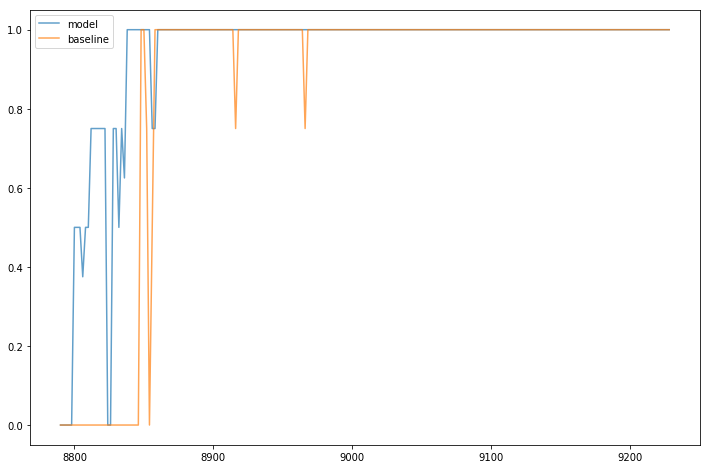

In [30]:
def get_avg_by_frame(PER_GTID, actor):
    FR_act = [frame for frame in PER_GTID[actor]['frame']]
    LA_act = np.array([frame for frame in PER_GTID[actor]['larms']])
    UA_act = np.array([frame for frame in PER_GTID[actor]['uarms']])
    LL_act = np.array([frame for frame in PER_GTID[actor]['llegs']])
    UL_act = np.array([frame for frame in PER_GTID[actor]['ulegs']])
    AV_act = (LA_act + UA_act + LL_act + LL_act) / 4
    return FR_act, AV_act

FR_act1, AV_act1 = get_avg_by_frame(ULT_PER_GTID_model, 5)
FR_act2, AV_act2 = get_avg_by_frame(ULT_PER_GTID_baseline, 5)

print('model\t\t', np.mean(AV_act1))
print('baseline\t', np.mean(AV_act2))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(FR_act1, AV_act1, alpha=0.7, label='model')
ax.plot(FR_act2, AV_act2, alpha=0.7, label='baseline')
plt.legend()
plt.show()

# REMEMBER RESULTS

## 300 frames per video, epi=40, fixed

In [16]:
# CAMERAS
# ==============================
# sequence: 160422_ultimatum1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.865
# 	larms: 0.6816666666666666
# 	ulegs: 0.10833333333333334
# 	llegs: 0.051666666666666666
# 	avg:   0.4266666666666667
# actor  1
# 	uarms: 0.1
# 	larms: 0.09166666666666666
# 	ulegs: 0.09333333333333334
# 	llegs: 0.08333333333333333
# 	avg:   0.09208333333333332
# actor  2
# 	uarms: 0.5886524822695035
# 	larms: 0.5620567375886525
# 	ulegs: 0.8617021276595744
# 	llegs: 0.6932624113475178
# 	avg:   0.676418439716312

# avg*:   0.3983894799054373

# model:
# --------
# actor  0
# 	uarms: 0.8416666666666667
# 	larms: 0.7833333333333333
# 	ulegs: 0.31333333333333335
# 	llegs: 0.25666666666666665
# 	avg:   0.5487500000000001
# actor  1
# 	uarms: 0.14833333333333334
# 	larms: 0.13
# 	ulegs: 0.15166666666666667
# 	llegs: 0.12333333333333334
# 	avg:   0.13833333333333334
# actor  2
# 	uarms: 0.9148936170212766
# 	larms: 0.8421985815602837
# 	ulegs: 0.9148936170212766
# 	llegs: 0.7145390070921985
# 	avg:   0.8466312056737588

# avg*:   0.5112381796690307


# ==============================
# sequence: 160224_haggling1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.6433333333333333
# 	larms: 0.44
# 	ulegs: 0.9583333333333334
# 	llegs: 0.41333333333333333
# 	avg:   0.61375
# actor  1
# 	uarms: 0.74
# 	larms: 0.6766666666666666
# 	ulegs: 0.86
# 	llegs: 0.39166666666666666
# 	avg:   0.6670833333333333
# actor  2
# 	uarms: 0.4266666666666667
# 	larms: 0.35333333333333333
# 	ulegs: 0.7183333333333334
# 	llegs: 0.6533333333333333
# 	avg:   0.5379166666666667

# avg*:   0.6062500000000001

# model:
# --------
# actor  0
# 	uarms: 0.9816666666666667
# 	larms: 0.8766666666666667
# 	ulegs: 0.9633333333333334
# 	llegs: 0.7366666666666667
# 	avg:   0.8895833333333334
# actor  1
# 	uarms: 0.9666666666666667
# 	larms: 0.94
# 	ulegs: 0.9616666666666667
# 	llegs: 0.9133333333333333
# 	avg:   0.9454166666666666
# actor  2
# 	uarms: 0.6616666666666666
# 	larms: 0.605
# 	ulegs: 0.6316666666666667
# 	llegs: 0.6116666666666667
# 	avg:   0.6275000000000001

# avg*:   0.8208333333333333


# ==============================
# sequence: 160906_pizza1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.7066666666666667
# 	larms: 0.6733333333333333
# 	ulegs: 0.37
# 	llegs: 0.32666666666666666
# 	avg:   0.5191666666666667
# actor  1
# 	uarms: 0.4666666666666667
# 	larms: 0.41833333333333333
# 	ulegs: 0.43
# 	llegs: 0.36833333333333335
# 	avg:   0.42083333333333334
# actor  2
# 	uarms: 0.535
# 	larms: 0.4066666666666667
# 	ulegs: 0.37833333333333335
# 	llegs: 0.22666666666666666
# 	avg:   0.38666666666666666

# avg*:   0.44222222222222224

# model:
# --------
# actor  0
# 	uarms: 0.9816666666666667
# 	larms: 0.965
# 	ulegs: 0.975
# 	llegs: 0.6583333333333333
# 	avg:   0.895
# actor  1
# 	uarms: 0.8966666666666666
# 	larms: 0.78
# 	ulegs: 0.6383333333333333
# 	llegs: 0.45666666666666667
# 	avg:   0.6929166666666666
# actor  2
# 	uarms: 0.955
# 	larms: 0.8566666666666667
# 	ulegs: 0.7566666666666667
# 	llegs: 0.5166666666666667
# 	avg:   0.77125

# avg*:   0.7863888888888889


In [17]:
# ==============================
# sequence: 160422_ultimatum1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.865
# 	larms: 0.6816666666666666
# 	ulegs: 0.10833333333333334
# 	llegs: 0.051666666666666666
# 	avg:   0.4266666666666667
# actor  1
# 	uarms: 0.1
# 	larms: 0.09166666666666666
# 	ulegs: 0.09333333333333334
# 	llegs: 0.08333333333333333
# 	avg:   0.09208333333333332
# actor  2
# 	uarms: 0.5886524822695035
# 	larms: 0.5620567375886525
# 	ulegs: 0.8617021276595744
# 	llegs: 0.6932624113475178
# 	avg:   0.676418439716312

# avg*:   0.3983894799054373

# model:
# --------
# actor  0
# 	uarms: 0.8416666666666667
# 	larms: 0.7833333333333333
# 	ulegs: 0.31333333333333335
# 	llegs: 0.25666666666666665
# 	avg:   0.5487500000000001
# actor  1
# 	uarms: 0.14833333333333334
# 	larms: 0.13
# 	ulegs: 0.15166666666666667
# 	llegs: 0.12333333333333334
# 	avg:   0.13833333333333334
# actor  2
# 	uarms: 0.9148936170212766
# 	larms: 0.8421985815602837
# 	ulegs: 0.9148936170212766
# 	llegs: 0.7145390070921985
# 	avg:   0.8466312056737588

# avg*:   0.5112381796690307


# ==============================
# sequence: 160224_haggling1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.6433333333333333
# 	larms: 0.44
# 	ulegs: 0.9583333333333334
# 	llegs: 0.41333333333333333
# 	avg:   0.61375
# actor  1
# 	uarms: 0.74
# 	larms: 0.6766666666666666
# 	ulegs: 0.86
# 	llegs: 0.39166666666666666
# 	avg:   0.6670833333333333
# actor  2
# 	uarms: 0.4266666666666667
# 	larms: 0.35333333333333333
# 	ulegs: 0.7183333333333334
# 	llegs: 0.6533333333333333
# 	avg:   0.5379166666666667

# avg*:   0.6062500000000001

# model:
# --------
# actor  0
# 	uarms: 0.9816666666666667
# 	larms: 0.8766666666666667
# 	ulegs: 0.9633333333333334
# 	llegs: 0.7366666666666667
# 	avg:   0.8895833333333334
# actor  1
# 	uarms: 0.9666666666666667
# 	larms: 0.94
# 	ulegs: 0.9616666666666667
# 	llegs: 0.9133333333333333
# 	avg:   0.9454166666666666
# actor  2
# 	uarms: 0.6616666666666666
# 	larms: 0.605
# 	ulegs: 0.6316666666666667
# 	llegs: 0.6116666666666667
# 	avg:   0.6275000000000001

# avg*:   0.8208333333333333


# ==============================
# sequence: 160906_pizza1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.7066666666666667
# 	larms: 0.6733333333333333
# 	ulegs: 0.37
# 	llegs: 0.32666666666666666
# 	avg:   0.5191666666666667
# actor  1
# 	uarms: 0.4666666666666667
# 	larms: 0.41833333333333333
# 	ulegs: 0.43
# 	llegs: 0.36833333333333335
# 	avg:   0.42083333333333334
# actor  2
# 	uarms: 0.535
# 	larms: 0.4066666666666667
# 	ulegs: 0.37833333333333335
# 	llegs: 0.22666666666666666
# 	avg:   0.38666666666666666

# avg*:   0.44222222222222224

# model:
# --------
# actor  0
# 	uarms: 0.9816666666666667
# 	larms: 0.965
# 	ulegs: 0.975
# 	llegs: 0.6583333333333333
# 	avg:   0.895
# actor  1
# 	uarms: 0.8966666666666666
# 	larms: 0.78
# 	ulegs: 0.6383333333333333
# 	llegs: 0.45666666666666667
# 	avg:   0.6929166666666666
# actor  2
# 	uarms: 0.955
# 	larms: 0.8566666666666667
# 	ulegs: 0.7566666666666667
# 	llegs: 0.5166666666666667
# 	avg:   0.77125

# avg*:   0.7863888888888889

## All images, epi=40

In [18]:
# ==============================
# sequence: 160422_ultimatum1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.9733333333333334
# 	larms: 0.89
# 	ulegs: 0.8766666666666667
# 	llegs: 0.87
# 	avg:   0.9025000000000001
# actor  1
# 	uarms: 0.38666666666666666
# 	larms: 0.33666666666666667
# 	ulegs: 0.15666666666666668
# 	llegs: 0.12666666666666668
# 	avg:   0.2516666666666667
# actor  2
# 	uarms: 0.9042553191489362
# 	larms: 0.875886524822695
# 	ulegs: 0.9397163120567376
# 	llegs: 0.9113475177304965
# 	avg:   0.9078014184397163
# actor  3
# 	uarms: 0.8527131782945736
# 	larms: 0.813953488372093
# 	ulegs: 0.8565891472868217
# 	llegs: 0.751937984496124
# 	avg:   0.8187984496124031
# actor  4
# 	uarms: 0.7563025210084033
# 	larms: 0.680672268907563
# 	ulegs: 0.4831932773109244
# 	llegs: 0.4327731092436975
# 	avg:   0.5882352941176471
# actor  5
# 	uarms: 0.85
# 	larms: 0.85
# 	ulegs: 0.8545454545454545
# 	llegs: 0.8545454545454545
# 	avg:   0.8522727272727273

# avg*:   0.7202124260181934

# model:
# --------
# actor  0
# 	uarms: 0.9166666666666666
# 	larms: 0.8433333333333334
# 	ulegs: 0.9733333333333334
# 	llegs: 0.9166666666666666
# 	avg:   0.9125
# actor  1
# 	uarms: 0.45
# 	larms: 0.32
# 	ulegs: 0.14666666666666667
# 	llegs: 0.12
# 	avg:   0.25916666666666666
# actor  2
# 	uarms: 0.9539007092198581
# 	larms: 0.9468085106382979
# 	ulegs: 0.950354609929078
# 	llegs: 0.9361702127659575
# 	avg:   0.946808510638298
# actor  3
# 	uarms: 0.9186046511627907
# 	larms: 0.6976744186046512
# 	ulegs: 0.9108527131782945
# 	llegs: 0.8255813953488372
# 	avg:   0.8381782945736435
# actor  4
# 	uarms: 0.9369747899159664
# 	larms: 0.8109243697478992
# 	ulegs: 0.5336134453781513
# 	llegs: 0.4411764705882353
# 	avg:   0.680672268907563
# actor  5
# 	uarms: 0.9272727272727272
# 	larms: 0.9227272727272727
# 	ulegs: 0.9636363636363636
# 	llegs: 0.9454545454545454
# 	avg:   0.9397727272727272

# avg*:   0.7628497446764829


# ==============================
# sequence: 160224_haggling1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.9433333333333334
# 	larms: 0.87
# 	ulegs: 0.9666666666666667
# 	llegs: 0.73
# 	avg:   0.8775000000000001
# actor  1
# 	uarms: 1.0
# 	larms: 0.9966666666666667
# 	ulegs: 1.0
# 	llegs: 0.9866666666666667
# 	avg:   0.9958333333333333
# actor  2
# 	uarms: 0.6933333333333334
# 	larms: 0.6066666666666667
# 	ulegs: 0.71
# 	llegs: 0.6533333333333333
# 	avg:   0.6658333333333333

# avg*:   0.8463888888888889

# model:
# --------
# actor  0
# 	uarms: 0.9833333333333333
# 	larms: 0.9333333333333333
# 	ulegs: 0.8466666666666667
# 	llegs: 0.57
# 	avg:   0.8333333333333333
# actor  1
# 	uarms: 1.0
# 	larms: 0.98
# 	ulegs: 0.97
# 	llegs: 0.93
# 	avg:   0.9700000000000001
# actor  2
# 	uarms: 0.85
# 	larms: 0.7433333333333333
# 	ulegs: 0.4766666666666667
# 	llegs: 0.4666666666666667
# 	avg:   0.6341666666666667

# avg*:   0.8125


# ==============================
# sequence: 160906_pizza1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.9933333333333333
# 	larms: 0.97
# 	ulegs: 1.0
# 	llegs: 0.9933333333333333
# 	avg:   0.9891666666666666
# actor  1
# 	uarms: 0.8233333333333334
# 	larms: 0.76
# 	ulegs: 0.88
# 	llegs: 0.74
# 	avg:   0.8008333333333333
# actor  2
# 	uarms: 0.87
# 	larms: 0.7266666666666667
# 	ulegs: 0.8933333333333333
# 	llegs: 0.7466666666666667
# 	avg:   0.8091666666666667
# actor  3
# 	uarms: 0.45
# 	larms: 0.1
# 	ulegs: 0.2733333333333333
# 	llegs: 0.016666666666666666
# 	avg:   0.21000000000000002
# actor  4
# 	uarms: 0.7009803921568627
# 	larms: 0.5294117647058824
# 	ulegs: 0.6274509803921569
# 	llegs: 0.36764705882352944
# 	avg:   0.5563725490196079

# avg*:   0.6731078431372548

# model:
# --------
# actor  0
# 	uarms: 0.9833333333333333
# 	larms: 0.9633333333333334
# 	ulegs: 0.9666666666666667
# 	llegs: 0.9566666666666667
# 	avg:   0.9675
# actor  1
# 	uarms: 0.98
# 	larms: 0.9433333333333334
# 	ulegs: 0.9433333333333334
# 	llegs: 0.7
# 	avg:   0.8916666666666666
# actor  2
# 	uarms: 0.7766666666666666
# 	larms: 0.69
# 	ulegs: 0.8633333333333333
# 	llegs: 0.76
# 	avg:   0.7725
# actor  3
# 	uarms: 0.83
# 	larms: 0.30666666666666664
# 	ulegs: 0.7133333333333334
# 	llegs: 0.27
# 	avg:   0.53
# actor  4
# 	uarms: 0.8284313725490197
# 	larms: 0.7401960784313726
# 	ulegs: 0.7450980392156863
# 	llegs: 0.5490196078431373
# 	avg:   0.715686274509804

# avg*:   0.7754705882352942